# Part 1: Introduction to Array-oriented programming

## What is "array-oriented programming"?

<br>

It's a programming paradigm, alongside paradigms like "imperative," "object-oriented," and "functional."

<br><br>

**In array-oriented programming, the primary data type is an array, and most functions perform one operation on all the elements of the array.**

<br><br>

In [1]:
import numpy as np

For instance, this is _not_ array-oriented:

<br>

In [2]:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
output_data = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

for i in range(len(input_data)):             # explicitly specifies an order of execution
    output_data[i] = input_data[i]**2        # user says what happens to each element

output_data

array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])

And this is _not_ array-oriented:

<br>

In [3]:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

output_data = np.fromiter(
    map(lambda x: x**2, input_data), int     # still focused on the individual element "x"
)

output_data

array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])

_This_ is array-oriented:

<br>

In [4]:
input_data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])

output_data = input_data**2                  # implicit indexes, no individual elements

output_data

array([ 1,  4,  9, 16, 25, 36, 49, 64, 81])

As with all programming paradigms, there isn't a sharply defined rule to cleanly separate them, and a single codebase can use several paradigms.

<br>

They are _styles_, and they're useful because they each bring different programming concepts into the foreground:

| Paradigm | Emphasizes |
|:-:|:-:|
| imperative/procedural | low-level algorithms |
| object-oriented | large-scale program structure |
| actor-based | temporal locality |
| literate | human instruction |
| event-driven | cause-and-effect |
| declarative | properties of desired result |
| symbolic | formula transformations |
| functional | data transformations |
| array-oriented | data distributions |

## What is array-oriented programming good for?

<br>

All of the languages/major libraries that emphasize array-oriented programming (that I know of):

<br>

<img src="../img/apl-timeline.svg" width="100%">

Almost all of them are intended as _interactive data-analysis_ environments.

(Fortran-90 is the only one that is not interactive.)

<br><br>

Almost all feature:

* interactive REPL (read-evaluate-print loop)
* concise notation
* unabashedly mathematical

### Distributions and interactivity

Array-oriented languages bring data _distributions_ to the foreground.

<br>

In [5]:
from hist import Hist  # histogram library

<br>

Given a large dataset...

In [6]:
dataset = np.random.normal(0, 1, 1000000)  # one MILLION data points

<br>

How are the data _distributed_?

In [7]:
Hist.new.Reg(100, -5, 5).Double().fill(dataset)

Hist(Regular(100, -5, 5, label='Axis 0'), storage=Double()) # Sum: 1000000.0

What happens if we apply a function to _all values in the distribution_?

In [8]:
dataset2 = dataset**2

<br>

In [9]:
Hist.new.Reg(100, -1, 10).Double().fill(dataset2)

Hist(Regular(100, -1, 10, label='Axis 0'), storage=Double()) # Sum: 998454.0 (1000000.0 with flow)

Can anyone guess what this distribution will look like?

In [10]:
dataset3 = np.sin(1/dataset2)

<br>

(I can't.)

In [11]:
Hist.new.Reg(100, -1, 1).Double().fill(dataset3)

Hist(Regular(100, -1, 1, label='Axis 0'), storage=Double()) # Sum: 1000000.0

**Human readability advantage:**

  * Mathematical expressions are concise, more convenient to type interactivity.

<br>

**Computational advantage:**

  * The right _part_ of the computation is accelerated: the loop over all values in the distribution.

## NumPy

<img src="../img/Numpy_Python_Cheat_Sheet.svg" width="100%">

NumPy's version of adding arrays elementwise is:

In [12]:
np.array([10, 20, 30]) + np.array([1, 2, 3])

array([11, 22, 33])

<br><br>

Since all scalar → scalar operators (and scalar → scalar functions in `np.*`) are promoted to elementwise operations on arrays, any [closed form](https://en.wikipedia.org/wiki/Closed-form_expression) expression duck-types between scalars and arrays.

In [13]:
def quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

Compute the quadratic formula on one set of scalar values:

In [14]:
a = 5
b = 10
c = -0.1

quadratic_formula(a, b, c)

np.float64(0.009950493836207741)

<br>

Compute the quadratic formula on a million values in arrays:

In [15]:
a = np.random.uniform(5, 10, 1000000)
b = np.random.uniform(10, 20, 1000000)
c = np.random.uniform(-0.1, 0.1, 1000000)

quadratic_formula(a, b, c)

array([ 0.00637958, -0.00162973, -0.00165645, ..., -0.00389341,
       -0.0008679 , -0.00663103])

### A note about performance

Although NumPy makes each step of the calculation fast, the whole expression is not optimized.

The execution of `quadratic_formula` is _similar to_ this:

In [16]:
def pedantic_quadratic_formula(a, b, c):
    tmp1 = np.negative(b)            # -b
    tmp2 = np.square(b)              # b**2
    tmp3 = np.multiply(4, a)         # 4*a
    tmp4 = np.multiply(tmp3, c)      # tmp3*c
    del tmp3
    tmp5 = np.subtract(tmp2, tmp4)   # tmp2 - tmp4
    del tmp2, tmp4
    tmp6 = np.sqrt(tmp5)             # sqrt(tmp5)
    del tmp5
    tmp7 = np.add(tmp1, tmp6)        # tmp1 + tmp6
    del tmp1, tmp6
    tmp8 = np.multiply(2, a)         # 2*a
    return np.divide(tmp7, tmp8)     # tmp7 / tmp8

<br>

In [17]:
pedantic_quadratic_formula(a, b, c)

array([ 0.00637958, -0.00162973, -0.00165645, ..., -0.00389341,
       -0.0008679 , -0.00663103])

Although it's faster than Python `for` loops...

In [18]:
%%timeit

imperative = np.empty_like(c)
for i, (ai, bi, ci) in enumerate(zip(a, b, c)):
    imperative[i] = quadratic_formula(ai, bi, ci)

1.3 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>

In [19]:
%%timeit

quadratic_formula(a, b, c)

2.61 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>

In [20]:
%%timeit

pedantic_quadratic_formula(a, b, c)

3.46 ms ± 550 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


...it's not as fast as a single "fused" loop over the data.

Other libraries fill this performance gap:

In [21]:
import numexpr as ne

ne.evaluate("(-b + sqrt(b**2 - 4*a*c)) / (2*a)");

<br>

In [22]:
import numba as nb

@nb.vectorize
def numba_quadratic_formula(a, b, c):
    return (-b + np.sqrt(b**2 - 4*a*c)) / (2*a)

numba_quadratic_formula(a, b, c);

<br>

In [23]:
%%timeit
quadratic_formula(a, b, c)         # NumPy (loop over data for each operation... mostly)

2.55 ms ± 168 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>

In [24]:
%%timeit
ne.re_evaluate()                   # NumExpr (fast virtual machine)

767 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<br>

In [25]:
%%timeit
numba_quadratic_formula(a, b, c)   # Numba (compiles with LLVM)

978 µs ± 4.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


<br>

Compiling Python or binding compiled code to Python is an open field, without a clearly dominant solution.

<img src="../img/history-of-bindings-2.svg" width="100%">

### Expressibility in NumPy

The amazing thing is that we can express so much by piecing together precompiled routines.

Combine

  * elementwise operations ("ufuncs")
  * broadcasting
  * basic and advanced slicing
  * slice-assignment
  * reshaping
  * reducers
  * specialized functions

to do great things!

**Example:** Compute the size of the spaces between consecutive elements.

In [26]:
array = np.array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])
array

array([1.1, 2.2, 3.3, 4.4, 5.5, 6.6, 7.7, 8.8, 9.9])

<br><br><br>

In [27]:
array[1:] - array[:-1]

array([1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1, 1.1])

<center>
<img src="../img/flat-operation.svg" width="70%">
</center>

<center>
<img src="../img/shifted-operation.svg" width="70%">
</center>

**Quizlet:** Compute the length of the curve sampled by arrays `x` and `y`.

In [28]:
t = np.linspace(0, 2*np.pi, 10000)
x = np.sin(3*t)
y = np.sin(4*t)

<br>

<center>
<img src="../img/length-by-segment.svg" width="55%">
</center>

<br>

In [29]:
import matplotlib.pyplot as plt

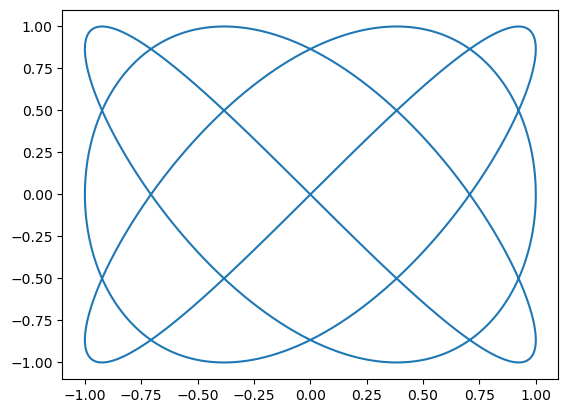

In [30]:
plt.plot(x, y);

<details>
<summary><b>Answer</b></summary>

```python
np.sum(np.sqrt((x[1:] - x[:-1])**2 + (y[1:] - y[:-1])**2))
```
</details>

**Example:** Big-endian to little-endian conversion.

(Note: `view` and `reshape` do not change the array data, only its interpretation.)

In [31]:
big_endian = np.array([1.1, 2.2, 3.3, 4.4, 5.5], dtype=">f8") # modern machines use little-endian
wrong_endianness = big_endian.view(np.float64)
wrong_endianness

array([-1.54234871e-180, -1.54234871e-180,  1.90359857e+185,
       -1.54234871e-180,  2.81419792e-320])

In [32]:
# to see the bytes as integers (0-255)
raw_bytes = wrong_endianness.view(np.uint8)
raw_bytes

array([ 63, 241, 153, 153, 153, 153, 153, 154,  64,   1, 153, 153, 153,
       153, 153, 154,  64,  10, 102, 102, 102, 102, 102, 102,  64,  17,
       153, 153, 153, 153, 153, 154,  64,  22,   0,   0,   0,   0,   0,
         0], dtype=uint8)

In [33]:
grouped = raw_bytes.reshape(len(raw_bytes) // 8, 8)
grouped

array([[ 63, 241, 153, 153, 153, 153, 153, 154],
       [ 64,   1, 153, 153, 153, 153, 153, 154],
       [ 64,  10, 102, 102, 102, 102, 102, 102],
       [ 64,  17, 153, 153, 153, 153, 153, 154],
       [ 64,  22,   0,   0,   0,   0,   0,   0]], dtype=uint8)

Note: `:` is a full slice (changing nothing) and `::-1` reverses a dimension (`step == -1`).

In [34]:
reversed_grouped = grouped[:, ::-1]
reversed_grouped

array([[154, 153, 153, 153, 153, 153, 241,  63],
       [154, 153, 153, 153, 153, 153,   1,  64],
       [102, 102, 102, 102, 102, 102,  10,  64],
       [154, 153, 153, 153, 153, 153,  17,  64],
       [  0,   0,   0,   0,   0,   0,  22,  64]], dtype=uint8)

In [35]:
flattened = reversed_grouped.reshape(len(raw_bytes))
flattened

array([154, 153, 153, 153, 153, 153, 241,  63, 154, 153, 153, 153, 153,
       153,   1,  64, 102, 102, 102, 102, 102, 102,  10,  64, 154, 153,
       153, 153, 153, 153,  17,  64,   0,   0,   0,   0,   0,   0,  22,
        64], dtype=uint8)

In [36]:
flattened.view(wrong_endianness.dtype)

array([1.1, 2.2, 3.3, 4.4, 5.5])

**Quizlet:** Downsample this curve to make it less noisy.

In [37]:
noisy_data = np.sin(np.linspace(0, 2*np.pi, 1000)) + np.random.normal(0, 0.5, 1000)

<br>

That is, replace every 10 consecutive array elements with their average value, reducing the number of array elements from 1000 to 100, but representing the same curve (ranging from ‒1 to 1).

Note: this is how `axis` works for reducers.

<center>
<img src="../img/example-reducer-2d.svg" width="40%">
</center>

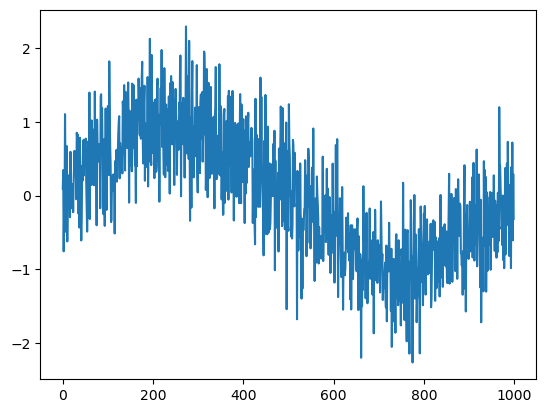

In [38]:
plt.plot(noisy_data);

<details>
<summary><b>Answer</b></summary>

```python
# group in 10s
reshaped_noisy_data = noisy_data.reshape(len(noisy_data) // 10, 10)
# and average
downsampled = np.mean(reshaped_noisy_data, axis=1)
plt.plot(downsampled);
```
</details>